- Diana Zaray Corado #191025
- Pablo Alejandro Méndez #19195
- Orlando Osberto Cabrera #19943
- Javier Alejandro Mejía Alecio #20304
- Erick Raúl Alvarez Melgar #20900
# Proyecto - Análisis Exploratorio

Guatemala es conocido como el país de la eterna primavera, debido a su diversidad de flora y fauna, además de contar
con un clima conocido como templado, es decir no existen climas extremos a lo largo del año. Sin embargo, así como
es conocido por su belleza natural, también es fuertemente reconocible por la corrupción y los bajos índices de calidad
de vida, y uno de ellos es el de mortalidad, la cual expresa la frecuencia con la cual ocurren las defunciones en una
población dada, en el caso de Guatemala, para el año 2019 fue de 4.72% (Datosmacro, 2021), es decir en promedio 5 muertes por cada 1000 habitantes.
A continuación se realizará un análisis exploratorio, sobre los datos de defunciones reportados por el Instituto Nacional de
Estadística de Guatemala -INE- de los años 2011 a 2020, y dentro de los cuales se pretende encontrar una situación problemática
la cual a su vez pueda ser resuelta con los datos analizados.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# General functions
def calculate_frequency(data, column, index='index', head = False):
    data_f = pd.DataFrame({
        'frequency': data[column].value_counts(),
        'relative_frequency (%)': data[column].value_counts(normalize=True)*100,
        'relative_acc_frequency': data[column].value_counts(normalize=True).cumsum()
    })
    data_f.reset_index(level=[0], inplace=True)
    data_f.rename(columns={index:column}, inplace=True)
    if head:
        left_aligned_df = data_f.head(20).style.set_properties(**{'text-align': 'center'})
    else:
        left_aligned_df = data_f.style.set_properties(**{'text-align': 'center'})
    display(left_aligned_df)
    return data_f

In [3]:
# Cargar los datos
deaths = pd.read_csv('muertes_final.csv')

C:\Users\Orlando\AppData\Local\Temp\ipykernel_13004\131818023.py:2: DtypeWarning: Columns (7,12,18,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  deaths = pd.read_csv('muertes_final.csv')


# Exploración de los datos
// Rúbrica
- Estudia las variables cuantitativas mediante técnicas de estadística descriptiva
- Hace gráficos exploratorios como histogramas, diagramas de cajas y bigotes, gráficos de dispersión,
que ayudan a explicar los datos.
- Analiza las correlaciones entre las variables, trata de explicar los outliers
(puntos atípicos) y toma decisiones acertadas ante la presencia de valores faltantes.
- Estudia las variables categóricas.
- Elabora gráficos de barra, tablas de frecuencia y de proporciones
- Explica muy bien todos los procedimientos y los hallazgos que va haciendo.
- Determina el mejor número de clusters a utilizar.
- Hace el agrupamiento con cualquiera de los algoritmos estudiados.
- Verifica la calidad del agrupamiento usando el método de la silueta.
- Interpreta los grupos, usando para eso las variables numéricas y categóricas dentro de cada grupo.

## ¿Cuáles son los datos?
Comience describiendo cuantas variables y observaciones tiene disponibles, el tipo de cada una de las variables.

### Clasificación de variables
**Cuantitativas**
No hay XD

**Cualitativas Ordinal**
- EDADIF → Edad del difunto
- ESCODIF → Escolaridad del difunto

**Cualitativa Nominal**
- DEPREG → Departamento de registro
- MUPREG → Municipio de registro
- MESREG → Mes de registro
- AÑOREG → Año de registro
- DEPOCU → Departamento de ocurrencia
- MUPOCU → Municipio de ocurrencia
- AREGAG → Área geográfica de ocurrencia
- SEXO
- DIAOCU → Día de ocurrencia
- MESOCU → Mes de ocurrencia
- AÑOOCU → Año de ocurrencia
- GETDIF → Grupo étnico del difunto
- ECIDIF → Estado civil del difunto
- OCUDIF → Ocupación del difunto
- PNADIF → País de nacimiento
- DNADIF → Departamento de nacimiento
- MNADIF → Municipio de nacimiento
- PREDIF → País de residencia
- DREDIF → Departamento de residencia
- MREDIF → Municipio de residencia
- CAUDEF → Causa de defunción
- ASIST → Asistencia recibida
- OCUR → Sitio de ocurrencia
- CERDEF → Quién certifica


## Preprocesamiento
Análisis de valores atípicos y tratamientos de valores faltantes

## Variables cuantitativas y su distribución
Haga un resumen de las variables numéricas e investigue si siguen una distribución normal.


## Variables cualitativas y su frecuencia
Elabore tablas de frecuencia para las variables categóricas, escriba lo que vaya encontrando.
// Acá también pueden ir preguntas


### Departamento de registro

### Municipio de registro

### Mes de registro

### Año de registro

### Departamento de ocurrencia

### Municipio de ocurrencia

### Área geográfica de ocurrencia

### SEXO

### Día de ocurrencia

### Mes de ocurrencia

### Año de ocurrencia

### Grupo étnico del difunto

### Estado civil del difunto
¿Cuál es el estado civil predominante en las muertes?

### Ocupación del difunto

### País de nacimiento

### Departamento de nacimiento

### Municipio de nacimiento

### País de residencia

### Departamento de residencia

### Municipio de residencia

### Causa de defunción

### Asistencia recibida
¿Cuál es el tipo de asistencia recibida predominante en las defunciones?

In [ ]:
assist = calculate_frequency(deaths, 'asist')

### Sitio de ocurrencia
¿Cuál es la proporción de personas que mueren en sus casas con respecto a las que mueren en hospitales?

In [ ]:
occur = calculate_frequency(deaths, 'ocur')

### Quién certifica

### Correlación entre los datos

## Definiendo elementos clave
Cruce las variables que considere que son las más importantes para hallar los elementos clave que lo pueden llevar a comprender lo que está causando el problema encontrado.

## Estado de los datos
Haga gráficos exploratorios que le dé ideas del estado de los datos.
// Acá van las preguntas


#### ¿Cuál es la relación entre el género y la edad en cuanto a las defunciones en Guatemala? ¿Las mujeres tienden a morir más jóvenes que los hombres?


In [ ]:
age_gender = deaths.groupby(by=['sexo', 'edad']).count()
# Hacer gráfico de barras

#### ¿Cuál es el porcentaje de población indígena que recibe asistencia hospitalaria?

In [ ]:
etnic_asist = deaths.groupby(by=['etnic', 'asist']).count()
# Hacer pie

#### ¿Es cierto que la soledad (soltería) incrementa la probabilidad de muerte temprana?

In [ ]:
lonely = deaths.groupby(by=['estado', 'edad']).count()
# Hacer barras


#### ¿Cómo es la distribución de las muertes de los jóvenes entre 18-30 que tienen una escolaridad por encima de diversificado?

In [ ]:
young = deaths.loc[(deaths['edad'] >= 18 & deaths['edad'] <= 30 & deaths['edad'] >= 18), ]
# hay que sacar ahora por el parámetro de estudio
# Hacer barras

### ¿En qué meses se dieron la mayor cantidad de defunciones?

In [4]:
month = deaths.groupby(["Mesocu"])["Mesocu"].count().sort_values(ascending=False)
month

Mesocu
Julio         73553
Agosto        69865
Diciembre     69332
Octubre       68468
Enero         68213
Junio         67813
Marzo         66918
Septiembre    66696
Mayo          66551
Noviembre     66100
Abril         65316
Febrero       60471
Name: Mesocu, dtype: int64

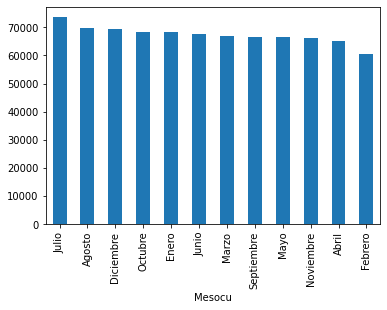

In [5]:
month.plot.bar()
del month

#### Como se puede observar en la gráfica, los meses con mayores defunciones son: julio, agosto y diciembre

### ¿En qué países se dieron la mayor cantidad de defunciones en los años 2019 y 2020 (pandemia)?

In [6]:
pandemia = pd.DataFrame(deaths.query("Añoreg>=2019"))
pandemia['Edadif'] = [-1 if year == "Ignorado" else year for year in pandemia["Edadif"]]
pais = pandemia.groupby(["Predif"])["Predif"].count().sort_values(ascending=False).head()
pais

Predif
Guatemala                    167596
Ignorado                      16302
Estados Unidos De América       148
El Salvador                      37
México                           26
Name: Predif, dtype: int64

<AxesSubplot:xlabel='Predif'>

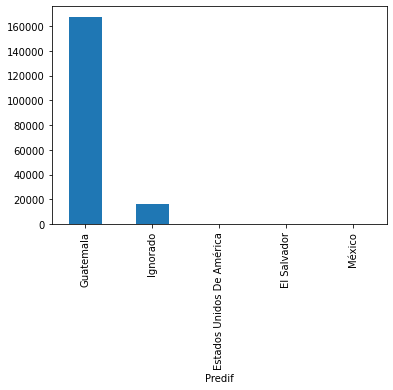

In [7]:
pais.plot.bar()

#### El país con mayor defunciones es Guatemala. Cabe mencionar que este resultado se deba, principalmente, a que la mayoría de datos que se recolectaron son provenientes de Guatemala

### Durante estos años, las personas que fallecieron tuvieron tratamiento médico? 

In [8]:
pandemia.groupby("Asist")["Asist"].count().sort_values(ascending=False)

Asist
Médica        93212
Ninguna       80592
Ignorado       5860
Empírica       3683
Paramédica      671
Comadrona       129
Name: Asist, dtype: int64

#### Como se puede observar, la cantidad de defunciones que hubieron en estos años de pandemia y que recibieron asistencia médica fueron de 93212 muertes, luego siguen las personas que no recibieron ningún tipo de asistencia médica. Esto se puede deber a que en esos tiempo, muchas personas se enfermaban y cuando necesitaban ir a un hospital, estos se encontraban llenos y no lograban encontrar cupo.

### ¿Existe alguna relación entre el sexo y la atención recibida que tuvieron los fallecidos en los años 2011 a 2020?


In [30]:
atencionGenero = deaths.groupby(["Asist","Sexo"])["Asist"].count().sort_values(ascending=False)
atencionGenero

Asist       Sexo  
Ninguna     Hombre    228798
Médica      Hombre    207723
            Mujer     172299
Ninguna     Mujer     169013
Empírica    Hombre      9465
            Mujer       8853
Ignorado    Hombre      6777
            Mujer       2705
Paramédica  Hombre      1893
            Mujer       1135
Comadrona   Mujer        391
            Hombre       244
Name: Asist, dtype: int64

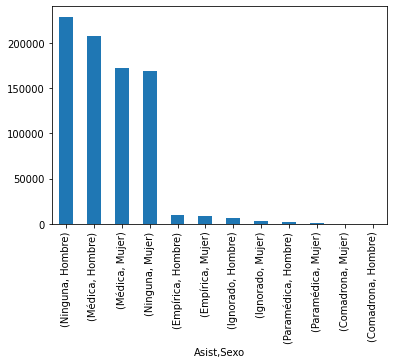

In [31]:
atencionGenero.plot.bar()
del atencionGenero

#### Como se puede observar en la gráfica, no hay alguna relación entre el género y la atención recibida, por lo que no se puede concluir que el género afecte en algo hacia la atención médica que uno puede recibir. Sin embargo, se puede notar que sin importar el género, existe una gran cantidad de personas que no recibe atención médica antes de morir.

### ¿En Guatemala, en qué lugares predominan las defunciones? ¿El servicio que ofrecen los hospitales privados es mejor que el de los hospitales públicos? 

In [10]:
guatemala = pd.DataFrame(deaths.query("Predif=='Guatemala'"))

In [11]:
municipios = guatemala.groupby("Mredif")["Mredif"].count().sort_values(ascending=False).head(10)
municipios

Mredif
Guatemala                80791
Mixco                    21792
Villa Nueva              16477
Quetzaltenango           10186
Escuintla                 9532
San Pedro Carchá          8691
San Juan Sacatepéquez     8587
Cobán                     7677
Jalapa                    7093
Totonicapán               6781
Name: Mredif, dtype: int64

<AxesSubplot:ylabel='Mredif'>

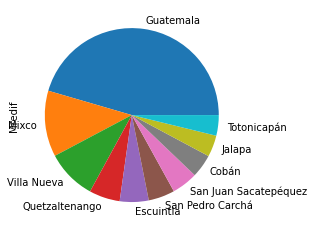

In [12]:
municipios.plot.pie()

In [13]:
lugar = guatemala.groupby("Ocur")["Ocur"].count().sort_values(ascending=False).head(10)
lugar

Ocur
Domicilio           429523
Hospital público    128415
Ignorado             37938
Seguro social        35107
Hospital privado     19461
Vía pública          19401
Otro                  7572
Centro de salud       1566
Lugar de trabajo        45
Name: Ocur, dtype: int64

<AxesSubplot:ylabel='Ocur'>

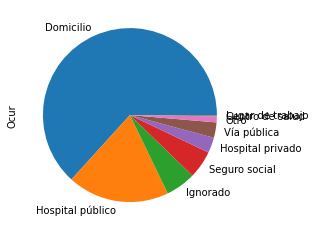

In [14]:
lugar.plot.pie()

In [15]:
del guatemala, lugar, municipios

### Cómo se puede observar en las dos gráficas de pie, el municipio con mayor cantidad de defunciones es Guatemala, luego le sigue Mixco, Villa Nueva y Quetzaltenango. 

### Cómo se puede observar, en los hospitales públicos hubieron mayores cantidad de defunciones que en hospitales privados, lo que podría indicar que el servicio de los hospitales privados es mejor, pero como se vió en la pregunta anterior y en la siguiente pregunta, el número de personas que tiene acceso a tratamientos médicos es muy baja, por lo que no se podría concluir que los hospitales privados son mejores que los públicos debido a que la cantidad de personas que pueden ir a un hospital privado es baja

### ¿Las personas fallecidas de 50 años o más recibieron buen tratamiento médico? ¿En qué lugares predominan sus muertes?

In [21]:
datos2 = deaths.copy()
datos2['Edadif'] = [-1 if year == "Ignorado" else int (year) for year in datos2["Edadif"]]

In [23]:
mayores = pd.DataFrame(datos2.query("Edadif>49"))

In [18]:
mayores.groupby("Asist")["Asist"].count().sort_values(ascending=False)

Asist
Ninguna       244804
Médica        233154
Empírica       11730
Ignorado        3915
Paramédica      1433
Comadrona        138
Name: Asist, dtype: int64

### Cómo se mencionó anteriormente, aquí se puede observar que las personas mayores a los 50 años no recibieron asistencia médica a la hora de su muerte, con una cantidad de 200701 defunciones registradas para ese caso. Luego siguen las defunciones que sí recibieron asistencia médica, con un valor de 196730.

In [24]:
del mayores, datos2

### ¿Quienes fueron las personas que más certificaron durante los años 2015 a 2020?

In [25]:
datos2 = pd.DataFrame(deaths.query("Añoreg>2014"))

In [26]:
cert = datos2.groupby("Cerdef")["Cerdef"].count().sort_values(ascending=False)
cert

Cerdef
Médico        293734
Ignorado      213060
Autoridad       2915
Paramédico      2128
Name: Cerdef, dtype: int64

<AxesSubplot:xlabel='Cerdef'>

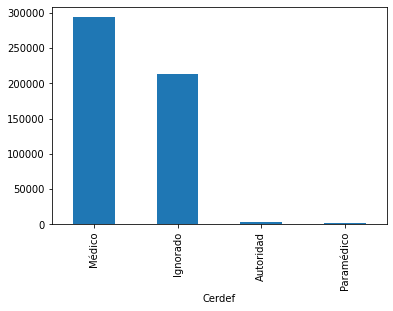

In [27]:
cert.plot.bar()

In [28]:
del datos2

### Como se puede observar en la gráfica de arriba, las personas que mayor certificaron son los médico, seguidos por los que se registraron como "ignorados".

## Agrupamiento
Haga un agrupamiento (clustering) e interprete los resultados.

# Análisis de resultados

## Situación problemática
Describa la situación problemática que lo lleva a acotar un problema a resolver.


## Problema científico
Enuncie un problema científico y unos objetivos preliminares.

## ¿Qué se tiene para responder el problema?
Describa los datos que tiene para responder el problema planteado. Esto incluye el estado en que encontró el o los conjuntos de datos y las operaciones de limpieza que le realizó, en caso de que hayan sido necesarias.

## Conclusiones
Escriba unas conclusiones con los hallazgos encontrados durante el análisis exploratorio